### Fundamentals of Natural Language Processing
# Negation and Uncertainty Detection using a Machine-Learning Based Approach

*Authors:*

> *Anna Blanco, Agustina Lazzati, Stanislav Bultaskii and Queralt Salvadó*

*Aims:*
> In natural language processing, accurately identifying negation and uncertainty is crucial for tasks like clinical information extraction or sentiment analysis. This project implements a deep learning-based approach to automatically detect such linguistic phenomena in text. By training sequence labeling models on annotated data, the system learns to recognize cue words (e.g., "not", "unlikely") and their corresponding scopes—the parts of the sentence affected by them. The goal is to improve text understanding by distinguishing between negated and uncertain statements.

## Preprocessing


In [27]:
# Import necessary libraries and functions
import json
import spacy
from collections import defaultdict
import re
import pandas as pd
import numpy as np
import pickle
import torch.nn as nn

Now we need to load preprocessed data from a .pkl file containing training and test data for the negation and uncertainty cues and scopes:



In [28]:
with open("lstm_data.pkl", "rb") as f:
    data_dict = pickle.load(f)

lstm_train_data_neg_cue = data_dict["lstm_train_data_neg_cue"]
lstm_train_data_neg_scope = data_dict["lstm_train_data_neg_scope"]
lstm_train_data_unc_cue = data_dict["lstm_train_data_unc_cue"]
lstm_train_data_unc_scope = data_dict["lstm_train_data_unc_scope"]

lstm_test_data_neg_cue = data_dict["lstm_test_data_neg_cue"]
lstm_test_data_neg_scope = data_dict["lstm_test_data_neg_scope"]
lstm_test_data_unc_cue = data_dict["lstm_test_data_unc_cue"]
lstm_test_data_unc_scope = data_dict["lstm_test_data_unc_scope"]

print(lstm_train_data_neg_cue[2])

(['antecedents', 'alergia', 'a', 'penicilina', 'y', 'cloramfenicol', '.'], [0, 0, 0, 0, 0, 0, 0])


Create unified labels by combining cue and scope labels into a single sequence:

"NEG_1" or "NSCO_1" for negation

"UNC_1" or "UNSCO_1" for uncertainty

In [29]:
def merge_labels(cue_labels, scope_labels, cue_prefix="CUE", scope_prefix="SCOPE"):
    merged = []
    for cue, scope in zip(cue_labels, scope_labels):
        if cue != 0:
            merged.append(f"{cue_prefix}_{str(cue)}")
        elif scope != 0:
            merged.append(f"{scope_prefix}_{str(scope)}")
        else:
            merged.append("0")
    return merged

Generate datasets of (tokens, merged_labels) for negation and uncertainty:

In [30]:
# Merge negation data
lstm_train_data_neg = [
    (tokens, merge_labels(cue_labels, scope_labels, cue_prefix="NEG", scope_prefix="NSCO"))
    for (tokens, cue_labels), (_, scope_labels) in zip(lstm_train_data_neg_cue, lstm_train_data_neg_scope)
]

lstm_test_data_neg = [
    (tokens, merge_labels(cue_labels, scope_labels, cue_prefix="NEG", scope_prefix="NSCO"))
    for (tokens, cue_labels), (_, scope_labels) in zip(lstm_test_data_neg_cue, lstm_test_data_neg_scope)
]

# Similarly for uncertainty
lstm_train_data_unc = [
    (tokens, merge_labels(cue_labels, scope_labels, cue_prefix="UNC", scope_prefix="UNSCO"))
    for (tokens, cue_labels), (_, scope_labels) in zip(lstm_train_data_unc_cue, lstm_train_data_unc_scope)
]

lstm_test_data_unc = [
    (tokens, merge_labels(cue_labels, scope_labels, cue_prefix="UNC", scope_prefix="UNSCO"))
    for (tokens, cue_labels), (_, scope_labels) in zip(lstm_test_data_unc_cue, lstm_test_data_unc_scope)
]

print(lstm_train_data_neg[3])

(['no', 'habitos', 'toxicos', '.'], ['NEG_1', 'NSCO_1', 'NSCO_1', 'NSCO_1'])


In [31]:
!pip install fasttext

import fasttext

# Download the English fastText model
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
# Unzip the downloaded file
!gunzip cc.en.300.bin.gz

--2025-05-27 17:32:53--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.51, 3.163.189.96, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  33.4MB/s    in 2m 51s  

2025-05-27 17:35:44 (25.2 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]

gzip: cc.en.300.bin already exists; do you wish to overwrite (y or n)? y
y
y
y
y
yes
y
y
^C


In [33]:
# Load pretrained FastText model (English, 300-dimensional vectors)
fasttext_model = fasttext.load_model("cc.en.300.bin")

ValueError: cc.en.300.bin cannot be opened for loading!

Create:

word2idx: maps each unique word to an index.

label2idx: maps each label (e.g., "NEG_1") to an index.

In [34]:
from collections import defaultdict

def build_vocab(sentences):
    word2idx = defaultdict(lambda: 0)  # unknown token index = 0
    idx = 1
    for sent in sentences:
        for word in sent:
            if word not in word2idx:
                word2idx[word] = idx
                idx += 1
    return dict(word2idx)

def build_label_vocab(labels_list):
    label_set = set()
    for labels in labels_list:
        label_set.update(labels)
    label2idx = {label: i for i, label in enumerate(sorted(label_set))}
    return label2idx

# Train and Test data for negations
all_train_sentences_neg = [x[0] for x in lstm_train_data_neg] # list of token lists
all_train_labels_neg = [x[1] for x in lstm_train_data_neg] # list of label lists

all_test_sentences_neg = [x[0] for x in lstm_test_data_neg]
all_test_labels_neg = [x[1] for x in lstm_test_data_neg]

# Train and Test data for uncertainties
all_train_sentences_unc = [x[0] for x in lstm_train_data_unc]
all_train_labels_unc = [x[1] for x in lstm_train_data_unc]

all_test_sentences_unc = [x[0] for x in lstm_test_data_unc]
all_test_labels_unc = [x[1] for x in lstm_test_data_unc]

# Merge all sentences and labels into single lists
all_sentences = (
    all_train_sentences_neg + all_test_sentences_neg +
    all_train_sentences_unc + all_test_sentences_unc
)

all_labels = (
    all_train_labels_neg + all_test_labels_neg +
    all_train_labels_unc + all_test_labels_unc
)

# Build vocabularies
word2idx = build_vocab(all_sentences)
label2idx = build_label_vocab(all_labels)

print(f"Vocabulary size (words): {len(word2idx)}")
print(f"Number of unique labels: {len(label2idx)}")

# Optional: check example mappings
print(f"Example word2idx: {list(word2idx.items())[:10]}")
print(f"Example label2idx: {list(label2idx.items())[:10]}")

Vocabulary size (words): 23359
Number of unique labels: 5
Example word2idx: [(' ', 1), ('nº', 2), ('historia', 3), ('clinica', 4), (':', 5), ('*', 6), ('nºepisodi', 7), ('sexe', 8), ('home', 9), ('data', 10)]
Example label2idx: [('0', 0), ('NEG_1', 1), ('NSCO_1', 2), ('UNC_1', 3), ('UNSCO_1', 4)]


In [35]:
import numpy as np
"""
Initializes an embedding matrix using FastText. If a word is not found, it is assigned a random vector.

"""
vocab_size = len(word2idx) + 1  # +1 for padding idx=0
embedding_matrix = np.zeros((vocab_size, 300))

for word, idx in word2idx.items():
    try:
        embedding_vector = fasttext_model.get_word_vector(word)
        embedding_matrix[idx] = embedding_vector
    except KeyError:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(300,))

In [36]:

def encode_sentences(sentences, word2idx):
    encoded = []
    for sent in sentences:
        encoded.append([word2idx.get(word, 0) for word in sent])
    return encoded

def encode_labels(labels, label2idx):
    encoded = []
    for lab_seq in labels:
        encoded.append([label2idx[str(label)] for label in lab_seq])
    return encoded

# Negation data
X_train_neg = encode_sentences(all_train_sentences_neg, word2idx)
y_train_neg = encode_labels(all_train_labels_neg, label2idx)

X_test_neg = encode_sentences(all_test_sentences_neg, word2idx)
y_test_neg = encode_labels(all_test_labels_neg, label2idx)

# Uncertainty data
X_train_unc = encode_sentences(all_train_sentences_unc, word2idx)
y_train_unc = encode_labels(all_train_labels_unc, label2idx)

X_test_unc = encode_sentences(all_test_sentences_unc, word2idx)
y_test_unc = encode_labels(all_test_labels_unc, label2idx)

# Show an example
print(X_train_neg[2], y_train_neg[2])

[45, 46, 47, 48, 49, 50, 44] [0, 0, 0, 0, 0, 0, 0]


In [37]:
from torch.nn.utils.rnn import pad_sequence
import torch
"""
Pads sequences so all have the same length, which is necessary for batch training.
"""
def pad_sequences(sequences, pad_value=0):
    # Convert lists of indices to torch tensors
    tensor_seqs = [torch.tensor(seq) for seq in sequences]
    # Pad sequences to the max length in the batch
    padded_seqs = pad_sequence(tensor_seqs, batch_first=True, padding_value=pad_value)
    return padded_seqs

# Pad inputs and labels (negation)
X_train_neg_padded = pad_sequences(X_train_neg, pad_value=0)
y_train_neg_padded = pad_sequences(y_train_neg, pad_value=label2idx.get('0', 0))

X_test_neg_padded = pad_sequences(X_test_neg, pad_value=0)
y_test_neg_padded = pad_sequences(y_test_neg, pad_value=label2idx.get('0', 0))

# Pad inputs and labels (uncertainty)
X_train_unc_padded = pad_sequences(X_train_unc, pad_value=0)
y_train_unc_padded = pad_sequences(y_train_unc, pad_value=label2idx.get('0', 0))

X_test_unc_padded = pad_sequences(X_test_unc, pad_value=0)
y_test_unc_padded = pad_sequences(y_test_unc, pad_value=label2idx.get('0', 0))

In [38]:
from torch.utils.data import Dataset, DataLoader
"""
Wraps data into PyTorch Dataset and DataLoader objects for use in model training and evaluation.
"""
class SequenceTaggingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset objects
train_dataset_neg = SequenceTaggingDataset(X_train_neg_padded, y_train_neg_padded)
test_dataset_neg = SequenceTaggingDataset(X_test_neg_padded, y_test_neg_padded)

train_dataset_unc = SequenceTaggingDataset(X_train_unc_padded, y_train_unc_padded)
test_dataset_unc = SequenceTaggingDataset(X_test_unc_padded, y_test_unc_padded)

# Create dataloaders
train_loader_neg = DataLoader(train_dataset_neg, batch_size=32, shuffle=True)
test_loader_neg = DataLoader(test_dataset_neg, batch_size=32, shuffle=False)

train_loader_unc = DataLoader(train_dataset_unc, batch_size=32, shuffle=True)
test_loader_unc = DataLoader(test_dataset_unc, batch_size=32, shuffle=False)

## LSTM Model

In [39]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(LSTMTagger, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        output = self.fc(lstm_out)
        return output

In [40]:
hidden_dim = 128
output_dim = len(label2idx)  # Number of unique labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMTagger(embedding_matrix, hidden_dim, output_dim).to(device)


In [41]:
criterion = nn.CrossEntropyLoss(ignore_index=label2idx["0"])  # ignore padding label
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [46]:
num_epochs = 20
loss_values = []  # Store total loss per epoch

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader_neg:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        outputs = outputs.view(-1, outputs.shape[-1])
        y_batch = y_batch.view(-1)

        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss_values.append(total_loss)  # Save loss after each epoch
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}", flush=True)


Epoch 1, Loss: nan
Epoch 2, Loss: 0.0047
Epoch 3, Loss: 0.0036
Epoch 4, Loss: 0.0029
Epoch 5, Loss: 0.0022
Epoch 6, Loss: 0.0017
Epoch 7, Loss: 0.0013
Epoch 8, Loss: 0.0011
Epoch 9, Loss: 0.0009
Epoch 10, Loss: 0.0007
Epoch 11, Loss: 0.0006
Epoch 12, Loss: 0.0005
Epoch 13, Loss: 0.0004
Epoch 14, Loss: 0.0003


KeyboardInterrupt: 

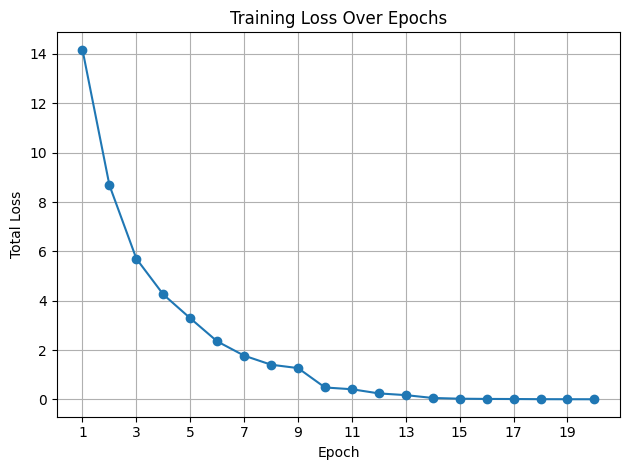

In [44]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), loss_values, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.grid(True)
plt.xticks(range(1, num_epochs + 1, max(1, num_epochs // 10)))
plt.tight_layout()
plt.show()


In [45]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader_neg:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        predicted = torch.argmax(outputs, dim=2)  # (batch_size, seq_len)

        mask = y_batch != label2idx["0"]
        correct += (predicted[mask] == y_batch[mask]).sum().item()
        total += mask.sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 99.60%
